<a href="https://colab.research.google.com/github/avgCoderr/Object-Detection-and-Labeling/blob/main/object_detection_and_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requirements to install before running the instances

In [ ]:
!pip install pytesseract
!pip install opencv-python
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

In [ ]:
!pip install gliner

Model used for PII identification : https://huggingface.co/urchade/gliner_multi_pii-v1

Gliner detects PIIs from string of texts
So it requires pre-procssing to convert image into text

In [ ]:
from gliner import GLiNER

model = GLiNER.from_pretrained("urchade/gliner_multi_pii-v1")

Importing relevant libraries

In [ ]:
from PIL import Image
import pytesseract
import cv2
import re
from PIL import Image, ImageDraw
from IPython.display import display

Test Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Apple/test_img_1.jpg'

In [ ]:
def clean_word(word):
    cleaned_word = re.sub(r'[^a-zA-Z0-9\s]', '', word)
    return cleaned_word.strip()

Reading the image and identifying text (words) mapped with its coordinates using 'Tesseract'

In [ ]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

custom_config = r'--oem 3 --psm 6'
results = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT, config=custom_config)

words_coords = []

for i in range(len(results['text'])):
    word = results['text'][i]
    x, y, w, h = results['left'][i], results['top'][i], results['width'][i], results['height'][i]

    words_coords.append({'word' : clean_word(word), 'coord': [x, y, w, h]})

In [ ]:
text_set = ''

for word_coord in words_coords:
    word = word_coord['word']
    text_set += word + ' '

Testing the model on the text extracted from the image

In [ ]:
gliner_labels = ["pnr",
                 "date",
                 "time",
                 "work",
                 "book",
                 "actor",
                 "email",
                 "person",
                 "address",
                 "company",
                 "character",
                 "credit card",
                 "phone number",
                 "full address",
                 "flight number",
                 "ticket number",
                 "booking number",
                 "driver licence",
                 "passport number",
                 "credit card number",
                 "Social Security Number",
                 "personally identifiable information"]
gliner_entities = model.predict_entities(text_set, gliner_labels)
gliner_entities

Displaying each identified word with its coordinates on image and pre-defined label

In [ ]:
gliner_required_coords = []
for entity in gliner_entities:
    text = entity['text']
    if entity["score"] < 0.5:
        continue
    split_text = text.split()
    for word_to_find in split_text:
        exists = any(item['word'] == word_to_find for item in words_coords)
        index = next((index for index, item in enumerate(words_coords) if item['word'] == word_to_find), None)
        print('Index: ' + str(index) + ' | Word: ' + str(words_coords[index]['word']) + ' | Coords: ' + str(words_coords[index]['coord']) + ' | Label: ' + str(entity['label']))
        gliner_required_coords.append(words_coords[index]['coord'])

Storing the coords to create a box

In [ ]:
gliner_required_coords

In [ ]:
gliner_img = Image.open(image_path)

draw = ImageDraw.Draw(gliner_img)
for coord in gliner_required_coords:
    x, y, w, h = coord
    draw.rectangle([x, y, x+w, y+h], outline = "red")

display(gliner_img.resize((int(gliner_img.width * 1), int(gliner_img.height * 1))))

Trying Presidio: https://microsoft.github.io/presidio/
Presidio provides two methods to identify PIIs
1. Detect PIIs from the image
2. Detect PIIs from a string of text

Presidio PII detection from pre-extracted text from image

In [ ]:
!pip install presidio-analyzer presidio-anonymizer

In [ ]:
from presidio_analyzer import AnalyzerEngine

analyzer = AnalyzerEngine()

# finding the supported labels from the model
recognizers = analyzer.get_recognizers(language="en")
presidio_labels = set()
for recognizer in recognizers:
    presidio_labels.update(recognizer.supported_entities)

presidio_labels = list(presidio_labels)

results = analyzer.analyze(text=text_set, entities=presidio_labels, language="en")


presidio_entities = []
for result in results:
    if result.score >= 0.4:
      presidio_entities.append({'text': text_set[result.start:result.end], 'label': result.entity_type})

In [ ]:
presidio_required_coords = []
for entity in presidio_entities:
    text = entity['text']
    split_text = text.split()
    for word_to_find in split_text:
        exists = any(item['word'] == word_to_find for item in words_coords)
        index = next((index for index, item in enumerate(words_coords) if item['word'] == word_to_find), None)
        print('Index: ' + str(index) + ' | Word: ' + str(words_coords[index]['word']) + ' | Coords: ' + str(words_coords[index]['coord']) + ' | Label: ' + str(entity['label']))
        presidio_required_coords.append(words_coords[index]['coord'])

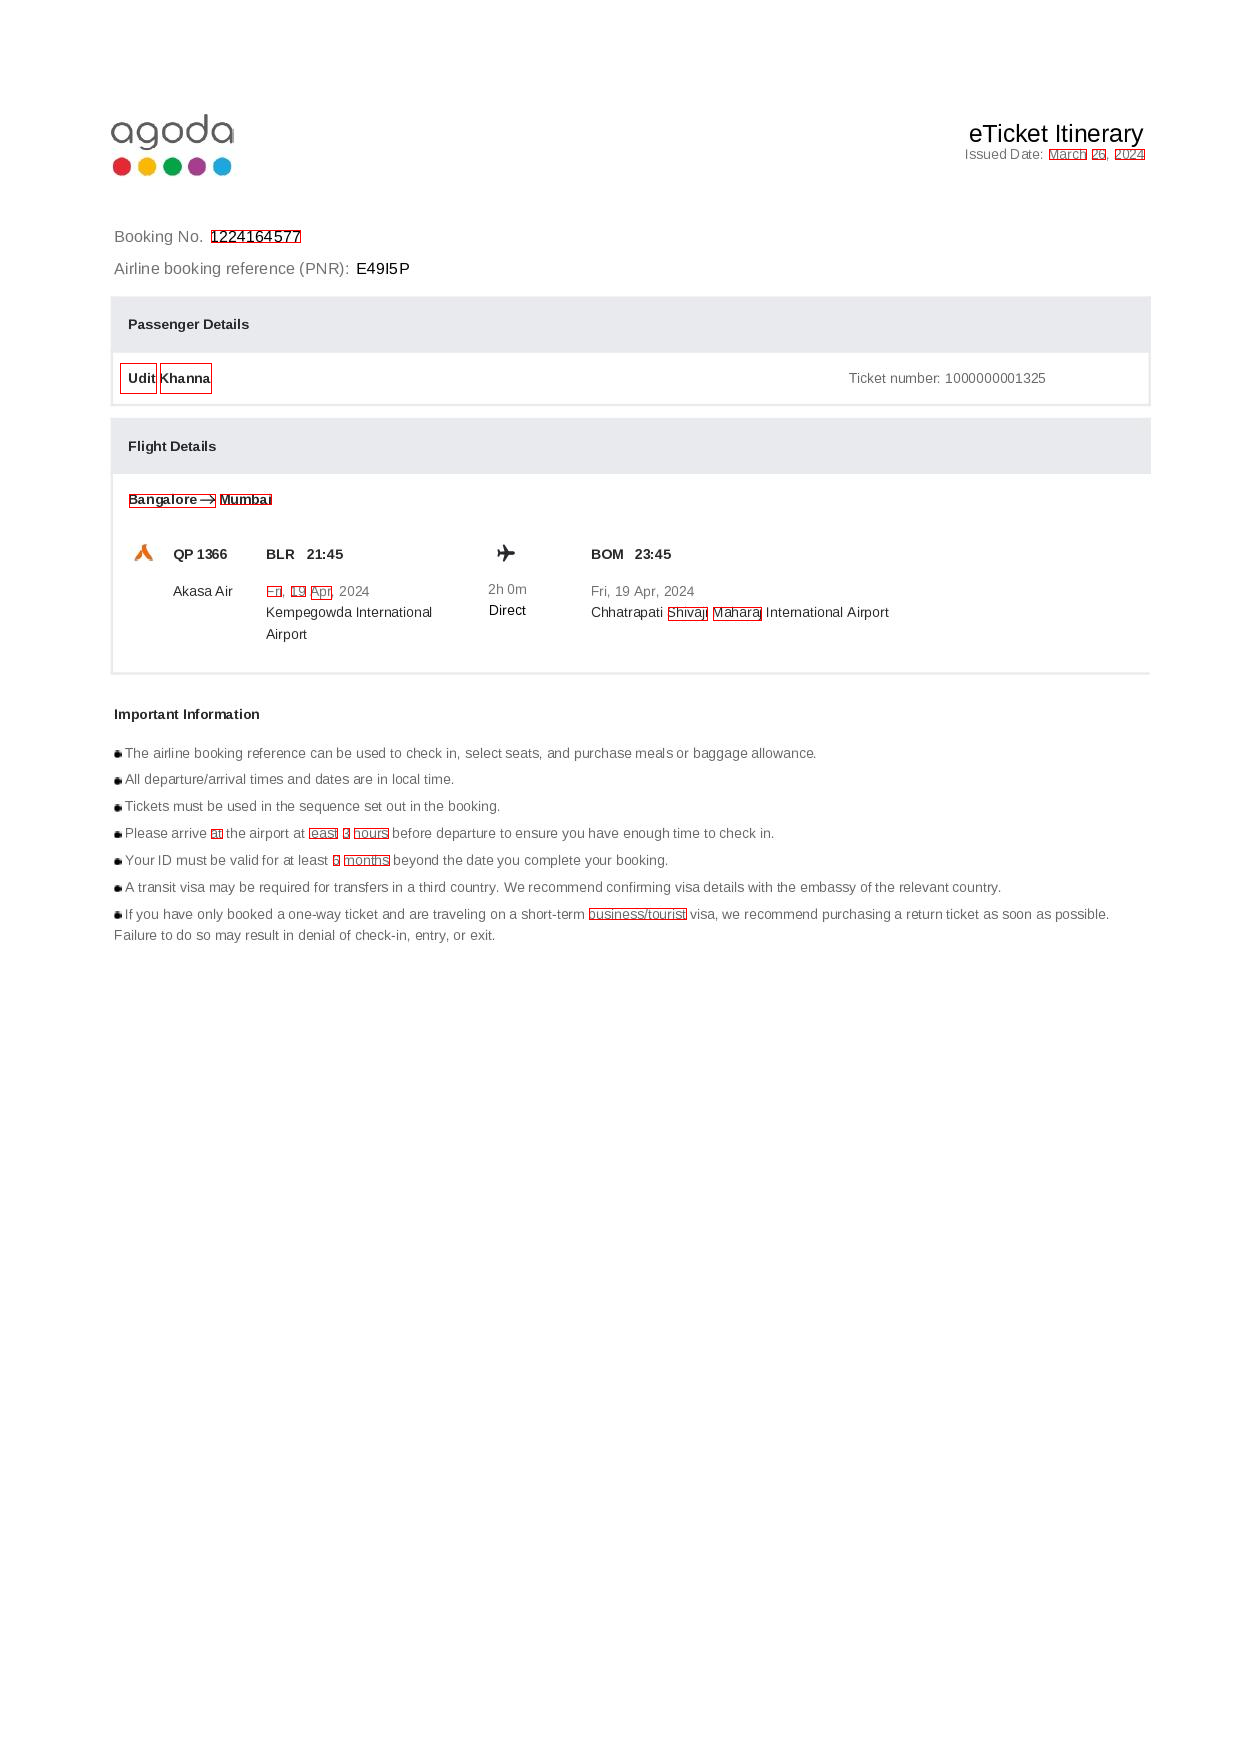

In [ ]:
presidio_img = Image.open(image_path)

draw = ImageDraw.Draw(presidio_img)
for coord in presidio_required_coords:
    x, y, w, h = coord
    draw.rectangle([x, y, x+w, y+h], outline = "red")

display(presidio_img.resize((int(presidio_img.width * 1), int(presidio_img.height * 1))))